# Ayoub SASSI

<br>

<table><tr>
<td> <img src="stock_market.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="tsf.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>


## TSF Task 7 : Stock Market Prediction using Numerical and Textual Analysis
### (Level - Advanced)


● Objective: Creating a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines <br>
● Stock to analyze and predict - S&P BSE SENSEX <br>
● Download the historical stock prices from finance.yahoo.com <br>
● Download the textual (news) data from https://bit.ly/36fFPI6 <br>
● Using Python for separate analysis and then combine the findings to create a hybrid model <br>


In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

#!pip3 install yfinance
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
#nltk.download()
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Reading the historic data of SENSEX from 2001 to 2020

df_price = yf.download('^BSESN', start='2001-01-02', end='2021-01-01')
df_price.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [3]:
df_price['Open'].value_counts(dropna=False)

3408.280029     2
17047.730469    2
2949.040039     2
16222.370117    2
3284.320068     2
               ..
15061.129883    1
34208.109375    1
11861.179688    1
6506.600098     1
14720.000000    1
Name: Open, Length: 4911, dtype: int64

In [4]:
df_price['High'].value_counts(dropna=False)

3109.909912     2
3198.810059     2
28110.369141    2
28143.279297    2
3435.679932     2
               ..
38571.230469    1
13998.480469    1
14547.410156    1
14036.610352    1
14663.259766    1
Name: High, Length: 4917, dtype: int64

In [5]:
df_price['Low'].value_counts(dropna=False)

14372.070312    2
19583.970703    2
9271.629883     2
25769.810547    2
5845.069824     1
               ..
11221.860352    1
2997.469971     1
4586.959961     1
9092.160156     1
14720.000000    1
Name: Low, Length: 4918, dtype: int64

In [6]:
df_price['Close'].value_counts(dropna=False)

3354.139893     2
3312.290039     2
16677.880859    2
3024.350098     2
7595.569824     1
               ..
4267.109863     1
21164.519531    1
19040.949219    1
20686.890625    1
32273.669922    1
Name: Close, Length: 4918, dtype: int64

In [7]:
df_price['Adj Close'].value_counts(dropna=False)

3354.139893     2
3312.290039     2
16677.880859    2
3024.350098     2
7595.569824     1
               ..
4267.109863     1
21164.519531    1
19040.949219    1
20686.890625    1
32273.669922    1
Name: Adj Close, Length: 4918, dtype: int64

In [8]:
df_price['Volume'].value_counts(dropna=False)

0         628
14600      52
11400      51
12200      49
11000      48
         ... 
199700      1
52200       1
44000       1
55000       1
24500       1
Name: Volume, Length: 457, dtype: int64

In [9]:
print(df_price.columns)
df_price.reset_index(inplace=True)
df_price.rename(columns={'Date': 'date','Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adjclose', 'Volume': 'volume'}, inplace = True)
df_price.head()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,date,open,high,low,close,adjclose,volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [10]:
#Reading the textual news data

df_news=pd.read_csv("C:\\Users\\asus\\Desktop\\Stock Market Prediction using Numerical and Textual Analysis\\india-news-headlines.csv")
df_news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [11]:
len(df_price), len(df_news)

(4922, 3424067)

In [12]:
df_price.isnull().count(), df_news.isnull().count()

(date        4922
 open        4922
 high        4922
 low         4922
 close       4922
 adjclose    4922
 volume      4922
 dtype: int64,
 publish_date         3424067
 headline_category    3424067
 headline_text        3424067
 dtype: int64)

#### Analysis on SENSEX data

In [13]:
#Analysing the SENSEX data

df_price =df_price.drop_duplicates()
df_price['date'] = pd.to_datetime(df_price['date'].dt.normalize())
df_price = df_price.filter(['date', 'close', 'open', 'high', 'low', 'volume'])
df_price.set_index('date', inplace= True)
df_price

,close,open,high,low,volume
date,,,,,
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0
...,...,...,...,...,...
2020-12-24,46973.539062,46743.488281,47053.398438,46539.019531,13700
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800


#### Analysis on Headlines data

In [14]:
df_news=df_news.drop_duplicates()
df_news['publish_date'] = pd.to_datetime(df_news['publish_date'],format= '%Y%m%d').dt.normalize()
df_news=df_news.filter(['publish_date','headline_text'])
df_news=df_news.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()
df_news.set_index('publish_date', inplace=True)
df_news

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [15]:
#Merging the required data in a single dataframe

df_stock=pd.concat([df_price,df_news],axis=1)
df_stock.dropna(axis=0, inplace=True)
df_stock

,close,open,high,low,volume,headline_text
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0,Light combat craft takes India into club class...
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0,"Sangh Parivar; Babri panel up the ante,Frontru..."
...,...,...,...,...,...,...
2020-12-24,46973.539062,46743.488281,47053.398438,46539.019531,13700.0,How to set the mood for sex during cold winter...
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800.0,Man recovers charred remains of 'thief' from h...
2020-12-30,47746.218750,47789.031250,47807.851562,47358.359375,15600.0,Numerology Readings 30 December 2020: Predicti...


In [16]:
#Using nltk - vader library to analyse the sentiments based on the headline data

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

sia = SentimentIntensityAnalyzer()

df_stock['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_stock['headline_text']]
df_stock['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_stock['headline_text']]
df_stock['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_stock['headline_text']]
df_stock['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_stock['headline_text']]
df_stock.head()

,close,open,high,low,volume,headline_text,Compound,Negative,Neutral,Positive
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0,Light combat craft takes India into club class...,0.9253,0.104,0.744,0.152
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026


In [17]:
#Removing headline data

df_stock.drop((['headline_text']), axis=1, inplace=True)
df_stock = df_stock[['close', 'Compound', 'Negative', 'Neutral', 'Positive', 'open', 'high', 'low', 'volume']]
df_stock.head()

,close,Compound,Negative,Neutral,Positive,open,high,low,volume
2001-01-02,4018.879883,-0.9621,0.119,0.817,0.064,3953.219971,4028.570068,3929.370117,0.0
2001-01-03,4060.020020,0.6322,0.084,0.817,0.098,3977.580078,4067.659912,3977.580078,0.0
2001-01-04,4115.370117,0.6648,0.077,0.843,0.080,4180.970215,4180.970215,4109.549805,0.0
2001-01-05,4183.729980,0.9253,0.104,0.744,0.152,4116.339844,4195.009766,4115.350098,0.0
2001-01-08,4120.430176,-0.9638,0.119,0.855,0.026,4164.759766,4206.720215,4101.529785,0.0


In [18]:
#Saving the compiled dataframe in a excel sheet that can be used later

df_stock.to_csv('stock_data.csv')

In [19]:
#Reading the stock_data 

stock_data=pd.read_csv('stock_data.csv')
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)
stock_data.set_index('Date', inplace=True)
stock_data.head()

,close,Compound,Negative,Neutral,Positive,open,high,low,volume
Date,,,,,,,,,
2001-01-02,4018.879883,-0.9621,0.119,0.817,0.064,3953.219971,4028.570068,3929.370117,0.0
2001-01-03,4060.020020,0.6322,0.084,0.817,0.098,3977.580078,4067.659912,3977.580078,0.0
2001-01-04,4115.370117,0.6648,0.077,0.843,0.080,4180.970215,4180.970215,4109.549805,0.0
2001-01-05,4183.729980,0.9253,0.104,0.744,0.152,4116.339844,4195.009766,4115.350098,0.0
2001-01-08,4120.430176,-0.9638,0.119,0.855,0.026,4164.759766,4206.720215,4101.529785,0.0


In [20]:
stock_data.describe(include='all')

,close,Compound,Negative,Neutral,Positive,open,high,low,volume
count,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4.893000e+03
mean,18685.761055,-0.877352,0.126638,0.786840,0.086516,18706.141903,18818.841446,18557.102644,8.070914e+04
std,11233.725489,0.441565,0.024107,0.032991,0.020832,11250.819220,11290.044725,11181.713549,1.069967e+06
min,2600.120117,-1.000000,0.000000,0.000000,0.000000,2621.889893,2682.590088,2594.870117,0.000000e+00
25%,8929.440430,-0.999800,0.113000,0.767000,0.076000,8939.379883,9033.990234,8799.009766,9.400000e+03
50%,17618.349609,-0.999200,0.128000,0.783000,0.086000,17650.820312,17769.250000,17500.789062,1.400000e+04
75%,27288.169922,-0.994700,0.142000,0.805000,0.097000,27316.429688,27445.240234,27159.449219,2.080000e+04
max,47751.328125,1.000000,0.444000,1.000000,0.608000,47789.031250,47896.968750,47602.121094,3.181510e+07


In [21]:
stock_data.isna().any()

close       False
Compound    False
Negative    False
Neutral     False
Positive    False
open        False
high        False
low         False
volume      False
dtype: bool

In [22]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4893 entries, 2001-01-02 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   close     4893 non-null   float64
 1   Compound  4893 non-null   float64
 2   Negative  4893 non-null   float64
 3   Neutral   4893 non-null   float64
 4   Positive  4893 non-null   float64
 5   open      4893 non-null   float64
 6   high      4893 non-null   float64
 7   low       4893 non-null   float64
 8   volume    4893 non-null   float64
dtypes: float64(9)
memory usage: 382.3+ KB


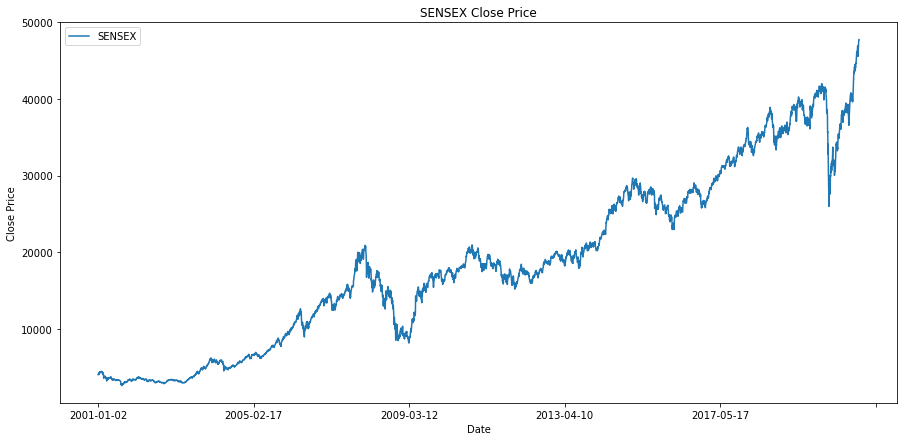

In [23]:
#Visualing the close price over the period of analysis

plt.figure(figsize=(15,7))
stock_data['close'].plot(label='SENSEX')
plt.title("SENSEX Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

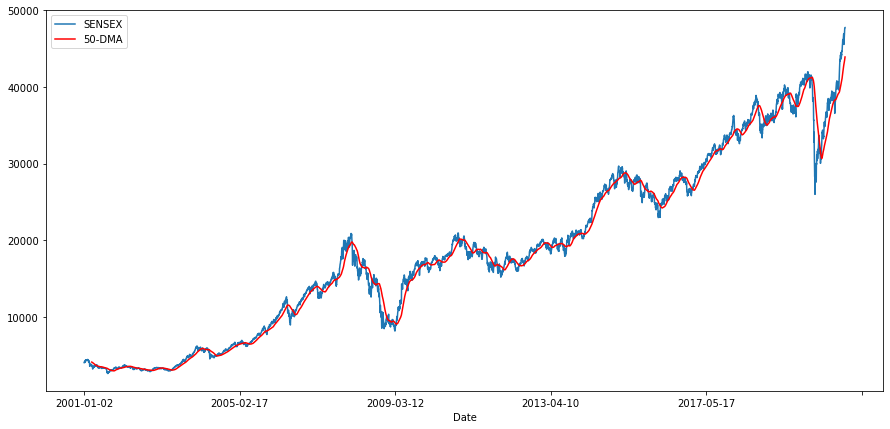

In [24]:
#Visualing the 50-Day moving average for measuring stock performance over the period

plt.figure(figsize=(15,7))
stock_data['close'].plot(label='SENSEX')
stock_data.rolling(window=50).mean()['close'].plot(label='50-DMA', color='r')
plt.legend()

 ### Data Preparation For Modelling


In [25]:
len(stock_data)

4893

In [26]:
#Calculating the number of datapoints for training and testing

percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3913
Number of records in Test Data: 980


In [27]:
#Allocating the datapoints for each column

steps_to_predict = 1

close_price = stock_data.iloc[start:total_data,0]        
compound = stock_data.iloc[start:total_data,1]           
negative = stock_data.iloc[start:total_data,2]           
neutral = stock_data.iloc[start:total_data,3]            
positive = stock_data.iloc[start:total_data,4]           
open_price = stock_data.iloc[start:total_data,5]         
high = stock_data.iloc[start:total_data,6]               
low = stock_data.iloc[start:total_data,7]                
volume = stock_data.iloc[start:total_data,8]             

print("Close Price:")
close_price

Close Price:


Date
2001-01-03     4060.020020
2001-01-04     4115.370117
2001-01-05     4183.729980
2001-01-08     4120.430176
2001-01-09     4125.310059
                  ...     
2020-12-24    46973.539062
2020-12-28    47353.750000
2020-12-29    47613.078125
2020-12-30    47746.218750
2020-12-31    47751.328125
Name: close, Length: 4892, dtype: float64

In [28]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2001-01-03,4060.020020,4115.370117,0.6322,0.6648,0.0,3977.580078,4067.659912,3977.580078
2001-01-04,4115.370117,4183.729980,0.6648,0.9253,0.0,4180.970215,4180.970215,4109.549805
2001-01-05,4183.729980,4120.430176,0.9253,-0.9638,0.0,4116.339844,4195.009766,4115.350098
2001-01-08,4120.430176,4125.310059,-0.9638,-0.9559,0.0,4164.759766,4206.720215,4101.529785
2001-01-09,4125.310059,4047.639893,-0.9559,-0.5719,0.0,4114.740234,4166.839844,4101.009766
2001-01-10,4047.639893,4296.689941,-0.5719,0.9295,0.0,4151.580078,4155.859863,4035.439941
2001-01-23,4296.689941,4326.419922,0.9295,-0.9039,0.0,4277.830078,4321.750000,4272.870117
2001-01-24,4326.419922,4330.220215,-0.9039,-0.9838,0.0,4320.509766,4339.410156,4295.709961
2001-01-25,4330.220215,4234.569824,-0.9838,0.9697,0.0,4327.839844,4341.330078,4273.700195


In [29]:
# setting the target variable as the shifted close_price

y = data['close_price_shifted']
y

Date
2001-01-03     4115.370117
2001-01-04     4183.729980
2001-01-05     4120.430176
2001-01-08     4125.310059
2001-01-09     4047.639893
                  ...     
2020-12-23    46973.539062
2020-12-24    47353.750000
2020-12-28    47613.078125
2020-12-29    47746.218750
2020-12-30    47751.328125
Name: close_price_shifted, Length: 4891, dtype: float64

In [30]:
# setting the future dataset for training the model

cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2001-01-03,4060.020020,0.6322,0.6648,0.0,3977.580078,4067.659912,3977.580078
2001-01-04,4115.370117,0.6648,0.9253,0.0,4180.970215,4180.970215,4109.549805
2001-01-05,4183.729980,0.9253,-0.9638,0.0,4116.339844,4195.009766,4115.350098
2001-01-08,4120.430176,-0.9638,-0.9559,0.0,4164.759766,4206.720215,4101.529785
2001-01-09,4125.310059,-0.9559,-0.5719,0.0,4114.740234,4166.839844,4101.009766
...,...,...,...,...,...,...,...
2020-12-23,46444.179688,-0.9996,-0.9971,10500.0,46072.300781,46513.320312,45899.101562
2020-12-24,46973.539062,-0.9971,-0.9997,13700.0,46743.488281,47053.398438,46539.019531
2020-12-28,47353.750000,-0.9997,-0.9998,9600.0,47153.589844,47406.718750,47148.238281


## Scaling

In [31]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

x, y

(array([[-0.93532553,  0.6322    ,  0.6648    , ..., -0.93997007,
         -0.93861222, -0.93822641],
        [-0.93287349,  0.6648    ,  0.9253    , ..., -0.93096396,
         -0.93359019, -0.93233057],
        [-0.92984511,  0.9253    , -0.9638    , ..., -0.93382579,
         -0.93296794, -0.93207144],
        ...,
        [ 0.98261339, -0.9997    , -0.9998    , ...,  0.97186267,
          0.98222136,  0.99045457],
        [ 0.99410179, -0.9998    , -0.9998    , ...,  0.98572369,
          0.99586481,  1.        ],
        [ 1.        , -0.9998    , -0.9996    , ...,  1.        ,
          1.        ,  0.99984189]]),
 array([[-0.93288109],
        [-0.92985305],
        [-0.93265695],
        ...,
        [ 0.99387613],
        [ 0.99977368],
        [ 1.        ]]))

## Train and Test data split

In timeseries data, an observation for a particular date is always dependent on the previous date records and the data like stock prices which is dependent on date, the dataset is divided into train and test dataset as below,

In [32]:
# preparing training and test dataset

X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets

print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (3913, 7) and y: (3913, 1)
Number of rows and columns in the Test set X: (977, 7) and y: (977, 1)


In [33]:
# reshaping the feature dataset into 3D for feeding into the LSTM model

X_train = X_train.reshape(X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3913, 7, 1)
Shape of Test set X: (977, 7, 1)


In [34]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2021)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [35]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
392/392 [==============================] - 18s 24ms/step - loss: 0.0646 - val_loss: 0.0315
Epoch 2/10
392/392 [==============================] - 6s 16ms/step - loss: 0.0029 - val_loss: 0.0109
Epoch 3/10
392/392 [==============================] - 6s 15ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/10
392/392 [==============================] - 6s 16ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/10
392/392 [==============================] - 6s 16ms/step - loss: 0.0012 - val_loss: 3.1014e-04
Epoch 6/10
392/392 [==============================] - 6s 15ms/step - loss: 0.0011 - val_loss: 1.8667e-04
Epoch 7/10
392/392 [==============================] - 7s 17ms/step - loss: 0.0012 - val_loss: 3.0153e-04
Epoch 8/10
392/392 [==============================] - 6s 16ms/step - loss: 9.6898e-04 - val_loss: 2.2754e-04
Epoch 9/10
392/392 [==============================] - 7s 17ms/step - loss: 9.1277e-04 - val_loss: 1.9213e-04
Epoch 10/10
392/392 [==============================] - 6s 16ms

## Prediction

In [36]:
#Prediction of stock data using the test dataset

predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[27094.309],
       [27301.271],
       [27455.656],
       [27568.004],
       [27496.678]], dtype=float32)

## Model Evaluation

In [37]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

977/977 [==============================] - 4s 4ms/step - loss: 7.4603e-04
Train Loss = 0.0003
Test Loss = 0.0007


In [38]:
# calculating root mean squared error using sklearn.metrics package

rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 36107.8783


In [39]:
# unscaling the test datasets
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

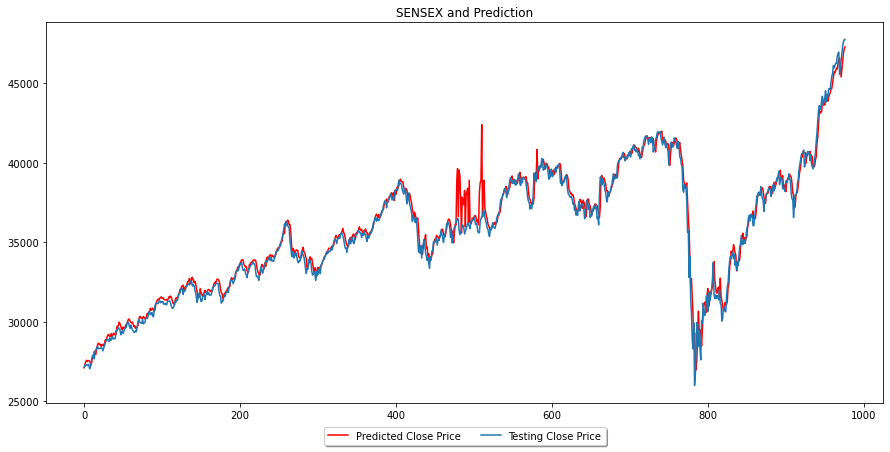

In [40]:
# plotting the prediction and original dataset on the same plot
    
plt.figure(figsize=(15,7))
plt.plot(predictions, label="Predicted Close Price", color='r')
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.title('SENSEX and Prediction')
plt.show()